# What can you find in this Notebook?

- Computation of distances of GSOD stations from the point of interest
- Visualisation of the GSOD distribution in Peru

In [1]:
import numpy as np
import pandas as pd
from math import sin, cos, sqrt, atan2, radians

In [2]:
metadata = pd.read_csv('gsod_peru_station_list.csv')

In [3]:
lat_gsod = metadata['lat']
lon_gsod = metadata['lon']

station_name = metadata['station name']

### Point of interest: Gallito Ciego Dam

In [4]:
latb = [-7.230]
lonb = [-79.172]

## ACP

In [5]:
lats = [-7.063781]
lons = [-79.552680]

In [6]:
def distance(lat1, lon1, lat2, lon2):
    # approximate radius of earth in km
    R = 6373.0

    lat1 = radians(lat1)
    lon1 = radians(lon1)
    lat2 = radians(lat2)
    lon2 = radians(lon2)

    dlat = lat2 - lat1
    dlon = lon2 - lon1

    a = sin(dlat / 2)**2 + cos(lat1) * cos(lat2) * sin(dlon / 2)**2
    c = 2 * atan2(sqrt(a), sqrt(1 - a))

    distance = R * c

    return distance

In [7]:
l = range(0, len(lat_gsod))
print(f'There are {len(lat_gsod)} GSOD stations in Peru.')

There are 35 GSOD stations in Peru.


In [8]:
for i in range(0, len(lats)):
    distances =[ ]
    for j in l:
        dis = distance(lat_gsod[j], lon_gsod[j], lats[i], lons[i])
        dis = round(np.min(dis), 1)
        print(f' {station_name[j]} is {dis} km away')
        distances.append(dis)
    print(f'Distance from nearest GSOD stations is {np.min(distances)} km')

 PEDRO CANGA is 401.1 km away
 CORONEL FRANCISCO SECADA VIGNETTA INTL is 781.6 km away
 CAPITAN MONTES is 334.6 km away
 CAPITAN FAP GUILLERMO CONCHA IBERICO is 237.8 km away
 JAEN is 186.2 km away
 MOISES BENZAQUEN RENGIFO is 401.3 km away
 JUAN SIMONS VELA is 286.7 km away
 CHACHAPOYAS is 210.5 km away
 CAPT JOSE A  QUINONES GONZALES INTL is 43.3 km away
 CADETE GUILLERMO DEL CASTILLO PAREDES is 356.6 km away
 GEN FAP ARMANDO REVOREDO IGLESIAS is 117.7 km away
 JUANJUI is 311.9 km away
 CAPITAN CARLOS MARTINEZ DE PINILLOS is 123.3 km away
 CAP FAP DAVID ABENZUR RENGIFO INTL is 567.9 km away
 TENIENTE JAIME A DE MONTREUIL MORALES is 258.2 km away
 TINGO MARIA is 458.6 km away
 COMANDANTE FAP GERMAN ARIAS GRAZIANI is 332.9 km away
 ALFEREZ FAP D F FERNANDINI is 483.4 km away
 MAZAMARI is 726.0 km away
 ATALAYA is 755.2 km away
 MATUCANA is 635.1 km away
 FRANCISCO CARLE is 689.8 km away
 JORGE CHAVEZ INTL is 612.9 km away
 PADRE ALDAMIZ is 1288.4 km away
 CORONEL FAP ALFREDO MENDIVIL D

## Dataviz

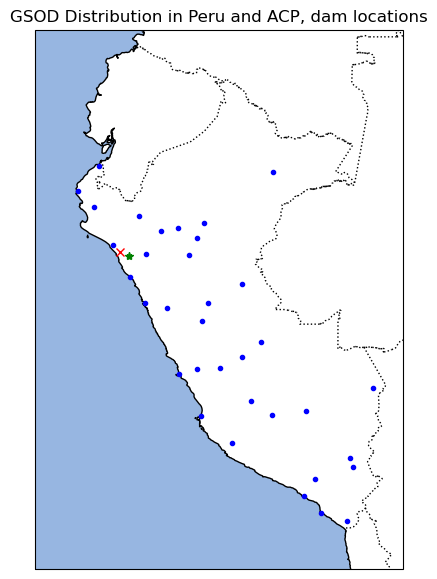

In [9]:
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(7,7))
ax = fig.add_subplot(1, 1, 1, projection=ccrs.PlateCarree())
ax.set_extent([-83, -68, -20, 2])

df = metadata
ax.add_feature(cfeature.OCEAN)
ax.add_feature(cfeature.COASTLINE)
ax.add_feature(cfeature.BORDERS, linestyle=':')
ax.plot(df.lon, df.lat, '.', color='blue')
ax.set_title('GSOD Distribution in Peru and ACP, dam locations');
ax.plot(lons, lats, 'x', color ='r')
ax.plot(lonb, latb, '*', color = 'g')

fig.savefig('acp_gsod.png')

## Zoom

Define the box where there are all the interesting stations (here Northern Peru because it’s where we have the forecast data from Copernicus C3S).

In [10]:
lon_box_min, lon_box_max  = -82, -74
lat_box_min, lat_box_max = -13.4, -3.4

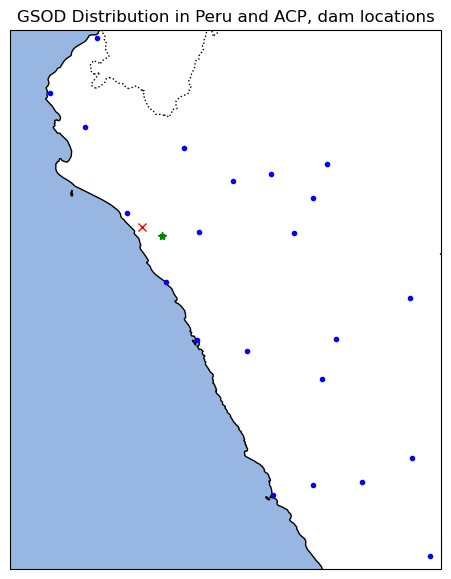

In [11]:
fig = plt.figure(figsize=(7,7))
ax = fig.add_subplot(1, 1, 1, projection=ccrs.PlateCarree())
ax.set_extent([lon_box_min, lon_box_max, lat_box_min, lat_box_max])

ax.add_feature(cfeature.OCEAN)
ax.add_feature(cfeature.COASTLINE)
ax.add_feature(cfeature.BORDERS, linestyle=':')
ax.plot(df.lon, df.lat, '.', color='blue')
ax.set_title('GSOD Distribution in Peru and ACP, dam locations');
ax.plot(lons, lats, 'x', color ='r')
ax.plot(lonb, latb, '*', color = 'g')
fig.savefig('/home/jovyan/data/share/heloise/ESA-WP11/GSOD/figures/acp_gsod_north.png')

# Extract data

## We would like now to extract the values from the parquet files in data/historical/gsod/raw/

In [4]:
import pandas as pd
from functools import partial
import numpy as np
import datetime as dt

In [5]:
#all years stored in a parquet file
gsod_data_path = "/home/jovyan/data/historical/gsod/raw/all_years_gsod.parquet"

In [6]:
def create_data_loader():
    """Creates a partial function that encapsulates a call to read the GSOD station data. Similar
    to `load_metadata`, it passed all keyword arguments to the underlying `pd.read_parquet`, accepting
    filters.
    """
    return partial(pd.read_parquet, gsod_data_path)

In [15]:
box_select = (metadata['lon'].between(lon_box_min, lon_box_max) &
              metadata['lat'].between(lat_box_min, lat_box_max))
filtered_metadata = metadata[box_select]

# Data in the box
id_list = filtered_metadata['id'].tolist()

# Remove station without enough data
stations = data_loader = create_data_loader()
id_list_filtered = []
for ide in id_list:
    df = data_loader(filters=[
    ("id", "=", f'{ide}'),
    ("time", ">=", dt.datetime(1991, 1, 1)),
    ("time", "<=", dt.datetime(2016, 12, 31))
    ])

    count_all = df["tp"].count()
    if count_all > 1000:
        id_list_filtered.append(ide)
    else:
        print(f'Not enough data for station id {ide}, station removed.')

names = metadata.loc[metadata['id'].isin(id_list_filtered), 'station name']
elevs = metadata.loc[metadata['id'].isin(id_list_filtered), 'elev']

name_list = names.tolist()
elev_list = elevs.tolist()
print(f'There are {len(id_list_filtered)} GSOD stations with meteorological data in North Peru.')


Not enough data for station id 84410099999, station removed.
Not enough data for station id 84580099999, station removed.
Not enough data for station id 84600099999, station removed.
Not enough data for station id 84623199999, station removed.
There are 18 GSOD stations with meteorological data in North Peru.


In [7]:
# Box around Cajamarca region
box_select = (metadata['lon'].between(-80, -75) &
              metadata['lat'].between(-8.3, -5.3))
filtered_metadata = metadata[box_select]

# Data in the box
id_list = filtered_metadata['id'].tolist()

# Remove station without enough data
stations = data_loader = create_data_loader()
id_list_filtered = []
for ide in id_list:
    df = data_loader(filters=[
    ("id", "=", f'{ide}'),
    ("time", ">=", dt.datetime(1991, 1, 1)),
    ("time", "<=", dt.datetime(2016, 12, 31))
    ])

    count_all = df["tp"].count()
    if count_all > 1000:
        id_list_filtered.append(ide)
    else:
        print(f'Not enough data for station id {ide}, station removed.')

names = metadata.loc[metadata['id'].isin(id_list_filtered), 'station name']
elevs = metadata.loc[metadata['id'].isin(id_list_filtered), 'elev']

name_list = names.tolist()
elev_list = elevs.tolist()
print(f'There are {len(id_list_filtered)} GSOD stations with meteorological data in North Peru.')


Not enough data for station id 84410099999, station removed.
There are 8 GSOD stations with meteorological data in North Peru.


In [8]:
name_list

['MOISES BENZAQUEN RENGIFO',
 'JUAN SIMONS VELA',
 'CHACHAPOYAS',
 'CAPT JOSE A  QUINONES GONZALES INTL',
 'CADETE GUILLERMO DEL CASTILLO PAREDES',
 'GEN FAP ARMANDO REVOREDO IGLESIAS',
 'JUANJUI',
 'CAPITAN CARLOS MARTINEZ DE PINILLOS']

## Cumulative monthly precipitation for one station

### We load one station using its id

In [22]:
test = id_list[9]
print(test)

84472099999


In [23]:
stations = data_loader = create_data_loader()
df = data_loader(filters=[
    ("id", "=", f'{test}'),
    ("time", ">=", dt.datetime(1991, 1, 1)),
    ("time", "<=", dt.datetime(2020, 12, 31))
])

In [24]:
df

tmean  tmean_count   tmax tmax_flag   tmin tmin_flag  \
id          time                                                               
84472099999 1991-01-07  16.39            8  21.39         *   4.28       nan   
            1991-01-08  16.50           11  22.00         *   3.72       nan   
            1991-01-10  17.50            4  20.39         *  15.61         *   
            1991-01-11  17.11            6  20.72       nan   7.22       nan   
            1991-01-12  17.94            5  21.61         *  13.00         *   
...                       ...          ...    ...       ...    ...       ...   
            2020-12-27  14.11            9  16.00         *  11.00         *   
            2020-12-28  16.11           10  21.22         *  12.00         *   
            2020-12-29  18.78            9  22.00         *  13.00         *   
            2020-12-30  19.22           10  23.00         *  12.00         *   
            2020-12-31  17.67            9  22.00         *  12.00         *   

                          tp tp_flag  dew_point  dew_point_count  ...  \
id          time                                                  ...   
84472099999 1991-01-07  0.00       C       8.89                8  ...   
            1991-01-08  0.00       C       8.33               11  ...   
            1991-01-10  0.00       B       9.78                4  ...   
            1991-01-11  7.11       G      11.67                6  ...   
            1991-01-12  0.00       G       9.17                5  ...   
...                      ...     ...        ...              ...  ...   
            2020-12-27  0.00       I       4.22                9  ...   
            2020-12-28  0.00       I       5.61               10  ...   
            2020-12-29  0.00       I       3.56                9  ...   
            2020-12-30  0.00       I       5.28               10  ...   
            2020-12-31  0.00       I       4.00                9  ...   

                            stp  stp_count    vis  vis_count  wind_speed_mean  \
id          time                                                                
84472099999 1991-01-07      NaN          0  11.91          8             1.65   
            1991-01-08  73960.0          4  12.39         11             1.49   
            1991-01-10      NaN          0  13.04          4             1.29   
            1991-01-11  74020.0          4  13.20          6             2.57   
            1991-01-12      NaN          0  11.91          5             1.03   
...                         ...        ...    ...        ...              ...   
            2020-12-27      NaN          0   9.98          9             2.52   
            2020-12-28      NaN          0   9.98         10             2.37   
            2020-12-29      NaN          0   9.98          9             3.14   
            2020-12-30      NaN          0   9.98         10             3.14   
            2020-12-31      NaN          0   9.98          9             1.65   

                        wind_speed_mean_count  wind_speed_max  gust_max  snow  \
id          time                                                                
84472099999 1991-01-07                      8            8.18       NaN   NaN   
            1991-01-08                     11            5.71       NaN   NaN   
            1991-01-10                      4            5.09       NaN   NaN   
            1991-01-11                      6           10.29       NaN   NaN   
            1991-01-12                      5            5.09       NaN   NaN   
...                                       ...             ...       ...   ...   
            2020-12-27                      9            6.17       NaN   NaN   
            2020-12-28                     10            4.58       NaN   NaN   
            2020-12-29                      9            5.71       NaN   NaN   
            2020-12-30                     10            6.17       NaN   NaN   
       

In [25]:
df.describe()

,tmean,tmean_count,tmax,tmin,tp,dew_point,dew_point_count,slp,slp_count,stp,stp_count,vis,vis_count,wind_speed_mean,wind_speed_mean_count,wind_speed_max,gust_max,snow
count,7274.000000,7274.000000,7274.000000,7274.000000,6905.000000,7200.000000,7274.000000,0.0,7274.0,3081.000000,7274.000000,7159.000000,7274.000000,7219.000000,7274.000000,6843.000000,234.000000,0.0
mean,15.460828,9.658097,20.896226,6.621512,2.414978,8.646819,9.606269,NaN,0.0,74077.296332,1.758592,11.326138,8.813720,1.934490,9.573412,5.001508,10.905299,NaN
std,1.387945,5.094470,1.847429,3.199449,9.527499,2.404429,5.152779,NaN,0.0,258.815596,2.065279,2.086861,4.869853,0.981014,5.127916,1.570290,2.119736,NaN
min,6.390000,4.000000,13.390000,-4.780000,0.000000,-10.220000,0.000000,NaN,0.0,72910.000000,0.000000,6.120000,0.000000,0.000000,0.000000,0.980000,6.170000,NaN
25%,14.670000,4.000000,20.000000,4.000000,0.000000,7.110000,4.000000,NaN,0.0,74000.000000,0.000000,9.980000,4.000000,1.390000,4.000000,4.120000,9.310000,NaN
50%,15.500000,9.000000,21.000000,7.000000,0.000000,9.000000,9.000000,NaN,0.0,74070.000000,0.000000,9.980000,8.000000,1.900000,9.000000,5.090000,10.800000,NaN
75%,16.330000,15.000000,22.000000,9.000000,1.020000,10.500000,15.000000,NaN,0.0,74130.000000,4.000000,13.200000,15.000000,2.395000,15.000000,5.710000,11.780000,NaN
max,22.000000,17.000000,30.000000,18.000000,290.070000,14.780000,17.000000,NaN,0.0,81620.000000,7.000000,21.570000,16.000000,14.250000,17.000000,25.670000,21.970000,NaN


### Cumulative monthly precipitation in 2020

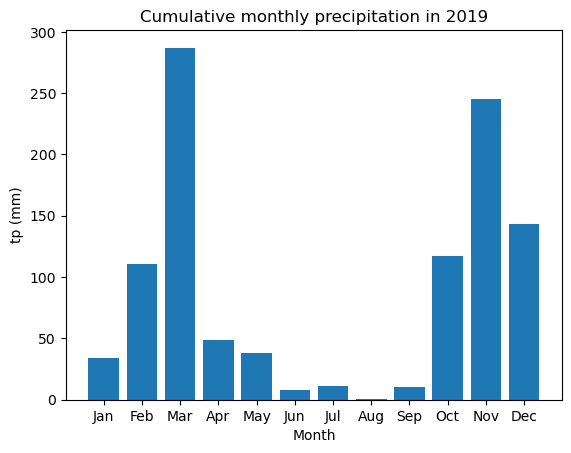

In [35]:
year = 2019
df_2020 = df[df.index.get_level_values('time').year == year]
df_2020.index = pd.to_datetime(df_2020.index.get_level_values('time'))
monthly_precipitation = df_2020['tp'].resample('M').sum()
month_labels = monthly_precipitation.index.strftime('%b')

plt.figure()
plt.bar(month_labels, monthly_precipitation, color='tab:blue')
plt.xlabel('Month')
plt.ylabel('tp (mm)')
plt.title(f'Cumulative monthly precipitation in {year}')
plt.show()

### Cumulative monthly precipitation from 1991 to 2020

In [22]:
count_nan = df["tp"].isna().sum()
print("Count NaN values in 'tp' data:", count_nan)
count_all = df["tp"].count()
print("Percentage of NaN values in the dataset:", "%.2f" % (100 * count_nan/count_all), "%")

Count NaN values in 'tp' data: 181
Percentage of NaN values in the dataset: 1.89 %


In [23]:
df.index = pd.to_datetime(df.index.get_level_values('time'))
monthly_cumulative = df['tp'].resample('M').sum()

In [24]:
monthly_mean = monthly_cumulative.groupby(monthly_cumulative.index.month).mean()

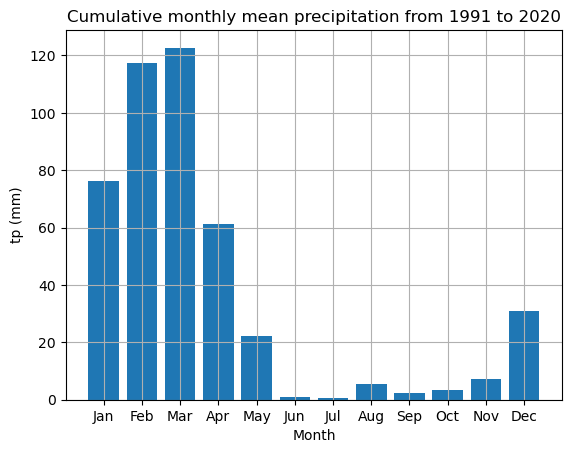

In [25]:
month_labels = monthly_cumulative[:12].index.strftime('%b')
fig = plt.figure()
plt.bar(month_labels, monthly_mean, color='tab:blue')
plt.xlabel('Month')
plt.ylabel('tp (mm)')
plt.title('Cumulative monthly mean precipitation from 1991 to 2020')
plt.grid(True)
plt.show()
#fig.savefig('acp_gsod_cumul.png')

## Cumulative monthly precipitation from 1991 to 2020 for each station


 MOISES BENZAQUEN RENGIFO station in Northern Peru_________________________

Percentage of NaN values in the dataset: 4.65 % 



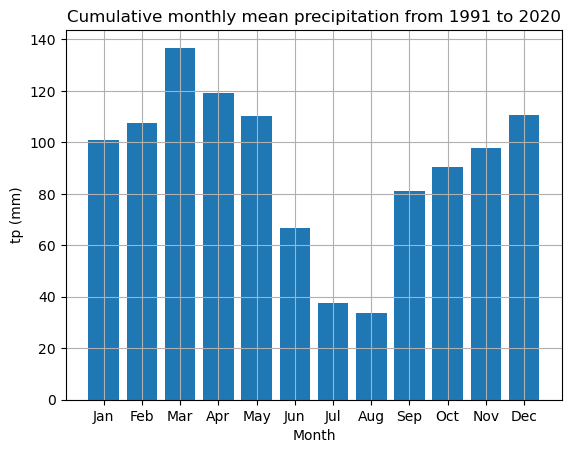


 JUAN SIMONS VELA station in Northern Peru_________________________

Percentage of NaN values in the dataset: 0.41 % 



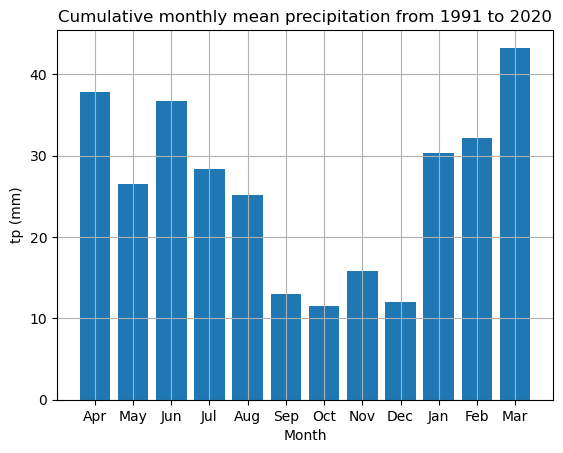


 CHACHAPOYAS station in Northern Peru_________________________

Percentage of NaN values in the dataset: 3.49 % 



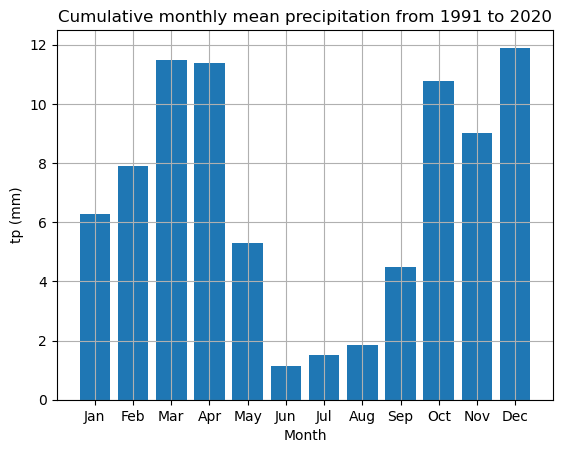


 CAPT JOSE A  QUINONES GONZALES INTL station in Northern Peru_________________________

Percentage of NaN values in the dataset: 0.75 % 



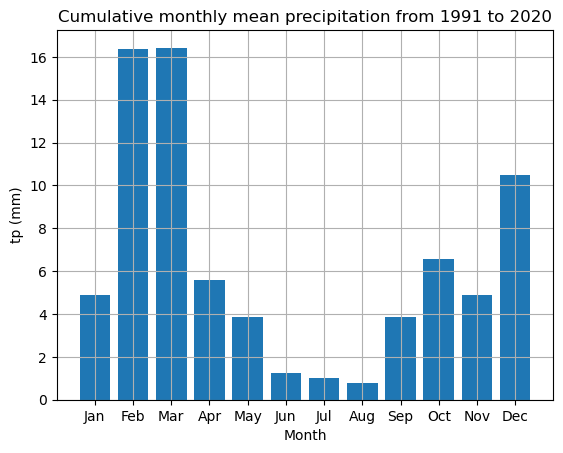


 CADETE GUILLERMO DEL CASTILLO PAREDES station in Northern Peru_________________________

Percentage of NaN values in the dataset: 3.92 % 



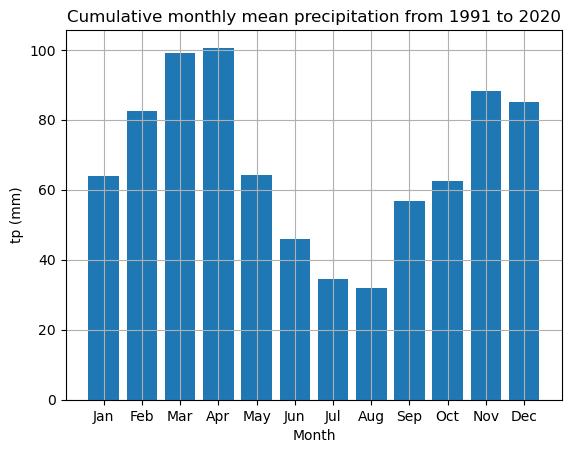


 GEN FAP ARMANDO REVOREDO IGLESIAS station in Northern Peru_________________________

Percentage of NaN values in the dataset: 5.34 % 



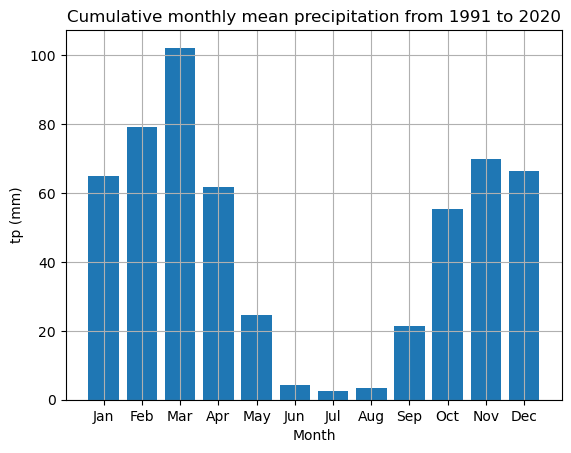


 JUANJUI station in Northern Peru_________________________

Percentage of NaN values in the dataset: 5.23 % 



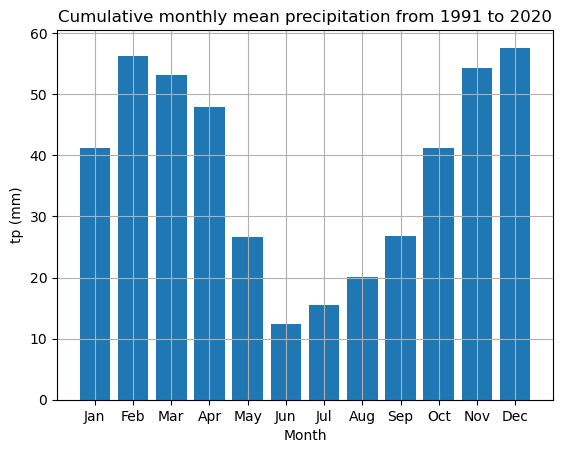


 CAPITAN CARLOS MARTINEZ DE PINILLOS station in Northern Peru_________________________

Percentage of NaN values in the dataset: 0.96 % 



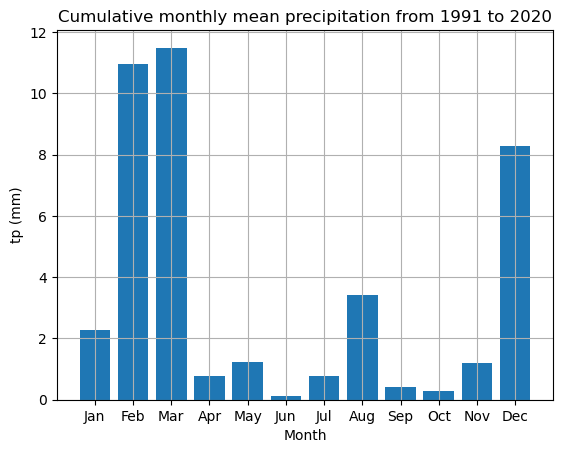

In [17]:
stations = data_loader = create_data_loader()
i = 0

for ide in id_list_filtered:
    
    df = data_loader(filters=[
    ("id", "=", f'{ide}'),
    ("time", ">=", dt.datetime(1991, 1, 1)),
    ("time", "<=", dt.datetime(2020, 12, 31))
    ])
    
    name_station = name_list[i]
    print(f'\n {name_station} station in Northern Peru_________________________\n')
    i = i + 1
    
    count_nan = df["tp"].isna().sum()
    count_all = df["tp"].count()
    print("Percentage of NaN values in the dataset:", "%.2f" % (100 * count_nan/count_all), "% \n")
    
    df.index = pd.to_datetime(df.index.get_level_values('time'))
    monthly_cumulative = df['tp'].resample('M').sum()
    month_labels = monthly_cumulative[:12].index.strftime('%b')
    monthly_cumulative.to_csv(f'tp_month_1991_2020_{name_station}.csv')
    
    monthly_mean = monthly_cumulative.groupby(monthly_cumulative.index.month).mean()
    monthly_mean.to_csv(f'tp_month_mean_1991_2020_{name_station}.csv')
    
    fig = plt.figure()
    plt.bar(month_labels, monthly_mean, color='tab:blue')
    plt.xlabel('Month')
    plt.ylabel('tp (mm)')
    plt.title('Cumulative monthly mean precipitation from 1991 to 2020')
    plt.grid(True)
    plt.show()
    fig.savefig(f'/home/jovyan/data/share/heloise/ESA-WP11/GSOD/figures/tp_month_mean_1991_2020_{name_station}.png')


 MOISES BENZAQUEN RENGIFO station in Northern Peru_________________________

Percentage of NaN values in the dataset: 3.85 % 



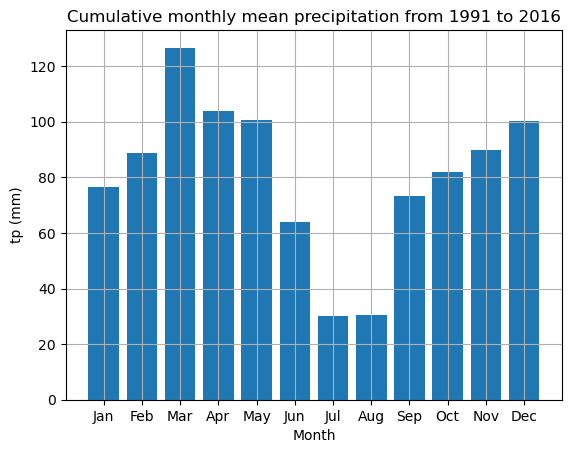


 JUAN SIMONS VELA station in Northern Peru_________________________

Percentage of NaN values in the dataset: 0.35 % 



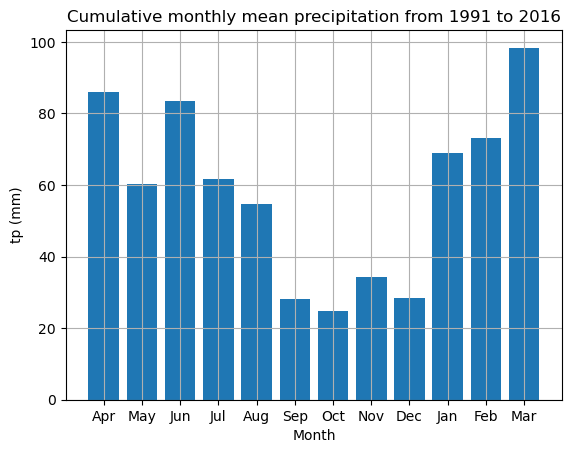


 CHACHAPOYAS station in Northern Peru_________________________

Percentage of NaN values in the dataset: 0.59 % 



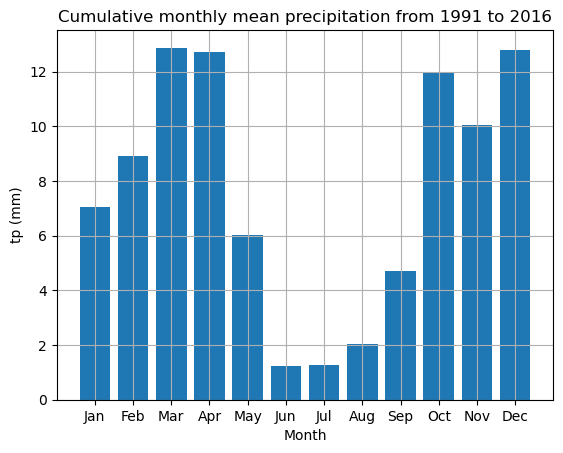


 CAPT JOSE A  QUINONES GONZALES INTL station in Northern Peru_________________________

Percentage of NaN values in the dataset: 0.68 % 



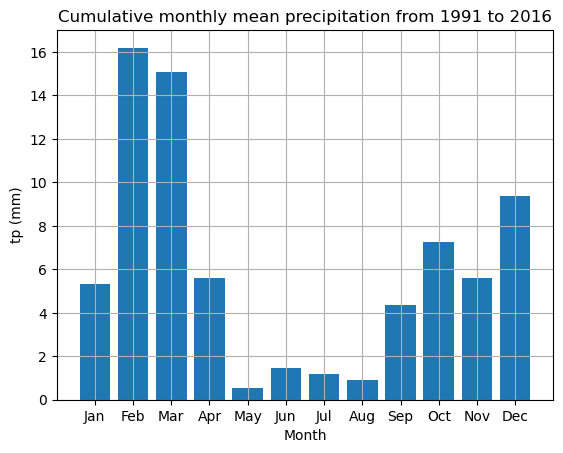


 CADETE GUILLERMO DEL CASTILLO PAREDES station in Northern Peru_________________________

Percentage of NaN values in the dataset: 3.40 % 



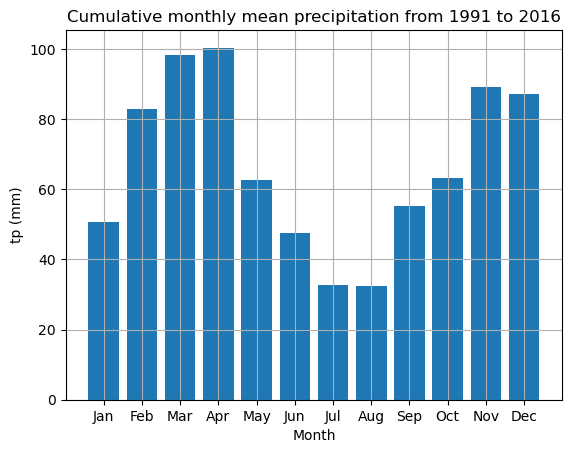


 GEN FAP ARMANDO REVOREDO IGLESIAS station in Northern Peru_________________________

Percentage of NaN values in the dataset: 4.76 % 



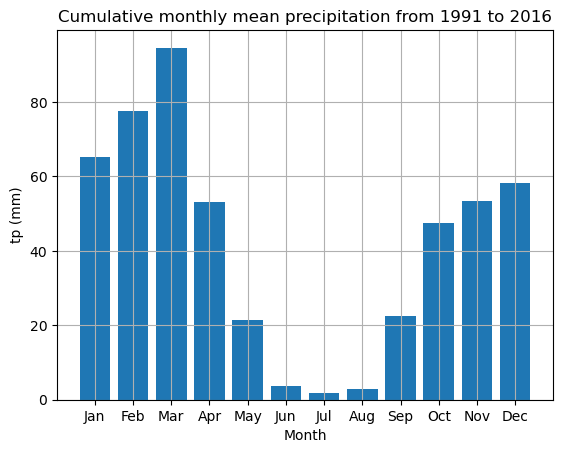


 JUANJUI station in Northern Peru_________________________

Percentage of NaN values in the dataset: 4.85 % 



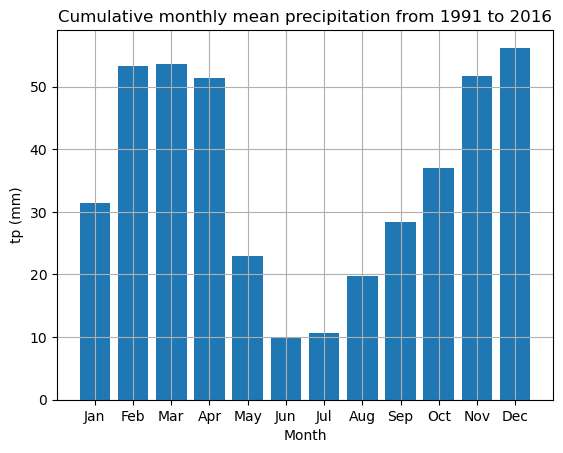


 CAPITAN CARLOS MARTINEZ DE PINILLOS station in Northern Peru_________________________

Percentage of NaN values in the dataset: 0.88 % 



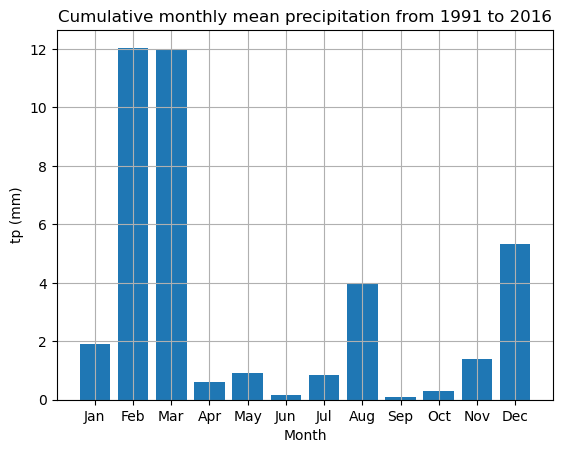

In [12]:
import matplotlib.pyplot as plt

stations = data_loader = create_data_loader()
i = 0

for ide in id_list_filtered:
    
    df_ref = data_loader(filters=[
    ("id", "=", f'{ide}'),
    ("time", ">=", dt.datetime(1991, 1, 1)),
    ("time", "<=", dt.datetime(2016, 12, 31))
    ])
    
    df_forecast = data_loader(filters=[
    ("id", "=", f'{ide}'),
    ("time", ">=", dt.datetime(2017, 1, 1))
    ])
    
    name_station = name_list[i]
    print(f'\n {name_station} station in Northern Peru_________________________\n')
    i = i + 1
    
    count_nan = df_ref["tp"].isna().sum()
    count_all = df_ref["tp"].count()
    print("Percentage of NaN values in the dataset:", "%.2f" % (100 * count_nan/count_all), "% \n")
    
    df_ref.index = pd.to_datetime(df_ref.index.get_level_values('time'))
    monthly_cumulative = df_ref['tp'].resample('M').sum()
    month_labels = monthly_cumulative[:12].index.strftime('%b')
    monthly_cumulative.to_csv(f'/home/joyvan/data/share/heloise/ESA-WP11/GSOD/files/tp_month_1991_2016_{name_station}.csv')
    
    monthly_mean = monthly_cumulative.groupby(monthly_cumulative.index.month).mean()
    monthly_mean.to_csv(f'/home/joyvan/data/share/heloise/ESA-WP11/GSOD/files/tp_month_mean_1991_2016_{name_station}.csv')
    
    df_forecast.index = pd.to_datetime(df_forecast.index.get_level_values('time'))
    monthly_cumulative_forecast = df_forecast['tp'].resample('M').sum()
    #month_labels = monthly_cumulative_forecast[:12].index.strftime('%b')
    monthly_cumulative_forecast.to_csv(f'/home/joyvan/data/share/heloise/ESA-WP11/GSOD/files/tp_month_forecast_{name_station}.csv')
    
    fig = plt.figure()
    plt.bar(month_labels, monthly_mean, color='tab:blue')
    plt.xlabel('Month')
    plt.ylabel('tp (mm)')
    plt.title('Cumulative monthly mean precipitation from 1991 to 2016')
    plt.grid(True)
    plt.show()
    fig.savefig(f'/home/joyvan/data/share/heloise/ESA-WP11/GSOD/figures/tp_month_mean_1991_2016_{name_station}.png')

# Separate the stations in 3 zones : dry, mountainous and tropical

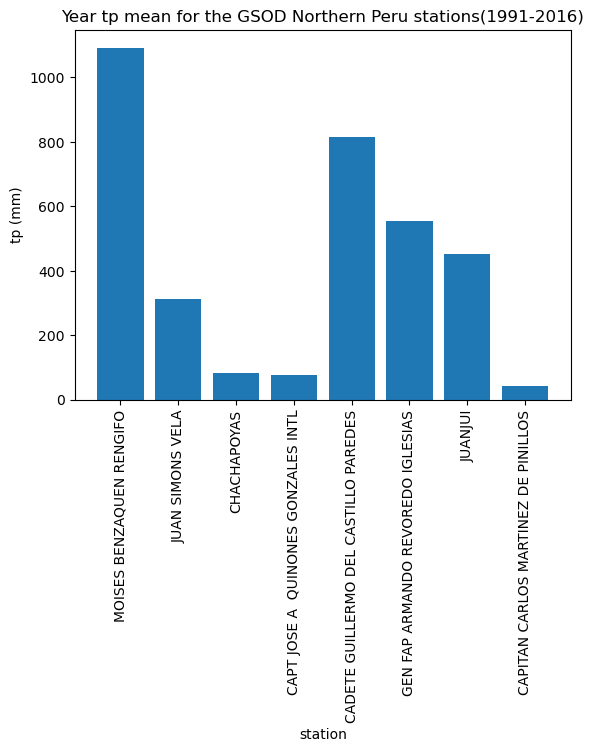

In [14]:
tp_range = []

costa_station = []
sierra_station = []
selva_station = []

for i, name in enumerate(name_list):
    df = pd.read_csv(f'tp_month_mean_1991_2020_{name}.csv')
    tp_station = df.tp.sum()
    tp_range.append(tp_station)
    elev = elev_list[i]
    if (tp_station < 453) & (elev < 500):
            costa_station.append(name)
    elif (tp_station<700):
        if (elev > 900):
            sierra_station.append(name)
        else:
            selva_station.append(name)
    elif (tp_station >= 700):
        selva_station.append(name)
    
plt.bar(name_list,tp_range)
plt.xlabel("station")
plt.ylabel("tp (mm)")
plt.xticks(rotation=90)
plt.title("Year tp mean for the GSOD Northern Peru stations(1991-2016)")
plt.show()

In [15]:
print(costa_station)
print(sierra_station)
print(selva_station)

['CAPT JOSE A  QUINONES GONZALES INTL', 'CAPITAN CARLOS MARTINEZ DE PINILLOS']
['CHACHAPOYAS', 'GEN FAP ARMANDO REVOREDO IGLESIAS']
['MOISES BENZAQUEN RENGIFO', 'JUAN SIMONS VELA', 'CADETE GUILLERMO DEL CASTILLO PAREDES', 'JUANJUI']


In [139]:
import folium
from folium.plugins import MarkerCluster
import base64
from folium import IFrame

# Create a map centered on the average coordinates
mean_lat = metadata['lat'].mean()
mean_lon = metadata['lon'].mean()
map_stations = folium.Map(location=[mean_lat, mean_lon], zoom_start=5)

# Create feature groups for each zone
costa_group = folium.FeatureGroup(name='Cost Stations')
sierra_group = folium.FeatureGroup(name='Sierra Stations')
selva_group = folium.FeatureGroup(name='Selva Stations')

width = 300
height = 200


# Iterate over stations in the metadata DataFrame
for index, row in metadata.iterrows():
    station_name = row['station name']
    lat = row['lat']
    lon = row['lon']

    # Check the zone membership and add to the corresponding group
    if station_name in costa_station:
        with open(f'/home/joyvan/data/share/heloise/ESA-WP11/GSOD/figures/tp_month_mean_1991_2020_{station_name}.png', 'rb') as f:
            encoded = base64.b64encode(f.read()).decode('UTF-8')
        #html = '<div style="width: {}px; height: {}px;"><img src="data:image/png;base64,{}" style="max-width: 100%; max-height: 100%;"></div>'.format(width, height, encoded)
        html = '<div style="text-align: center;"><h4 style="font-size: 12px;">{}</h4><img src="data:image/png;base64,{}" style="max-width: 100%; max-height: 100%;"></div>'.format(station_name, encoded)
        iframe = IFrame(html, width=width, height=height)
        popup = folium.Popup(iframe, max_width=400)
        folium.Marker(location=[lat, lon], tooltip=station_name, popup = popup, icon=folium.Icon(color='red')).add_to(costa_group)
    elif station_name in sierra_station:
        with open(f'/home/joyvan/data/share/heloise/ESA-WP11/GSOD/figures/tp_month_mean_1991_2020_{station_name}.png', 'rb') as f:
            encoded = base64.b64encode(f.read()).decode('UTF-8')
        html = '<div style="text-align: center;"><h4 style="font-size: 12px;">{}</h4><img src="data:image/png;base64,{}" style="max-width: 100%; max-height: 100%;"></div>'.format(station_name, encoded)
        iframe = IFrame(html, width=width, height=height)
        popup = folium.Popup(iframe, max_width=400)
        folium.Marker(location=[lat, lon], tooltip=station_name, popup = popup, icon=folium.Icon(color='blue')).add_to(sierra_group)
    elif station_name in selva_station:
        with open(f'/home/joyvan/data/share/heloise/ESA-WP11/GSOD/figures/tp_month_mean_1991_2020_{station_name}.png', 'rb') as f:
            encoded = base64.b64encode(f.read()).decode('UTF-8')
        html = '<div style="text-align: center;"><h4 style="font-size: 12px;">{}</h4><img src="data:image/png;base64,{}" style="max-width: 100%; max-height: 100%;"></div>'.format(station_name, encoded)
        iframe = IFrame(html, width=width, height=height)
        popup = folium.Popup(iframe, max_width=400)
        folium.Marker(location=[lat, lon], tooltip=station_name, popup = popup, icon=folium.Icon(color='green')).add_to(selva_group)
        
# Add the groups to the map
costa_group.add_to(map_stations)
sierra_group.add_to(map_stations)
selva_group.add_to(map_stations)

# Display and save the map
folium.LayerControl().add_to(map_stations)
map_stations.save('peru_map_clusters.html')
map_stations

In [16]:
# Export the filtered stations with their longitude and latitude into a .csv file
filtered_station = []

for index, row in metadata.iterrows():
    station_name = row['station name']
    lat = row['lat']
    lon = row['lon']
    
    if (station_name in costa_station):
        filtered_station.append({'name': station_name, 'lon': lon, 'lat':lat, 'cluster':'costa'})
    elif (station_name in sierra_station):
        filtered_station.append({'name': station_name, 'lon': lon, 'lat':lat, 'cluster':'sierra'})
    elif (station_name in selva_station):
        filtered_station.append({'name': station_name, 'lon': lon, 'lat':lat, 'cluster':'selva'})
    
df = pd.DataFrame(filtered_station)
df.to_csv('/home/joyvan/data/share/heloise/ESA-WP11/GSOD/files/filtered_stations_cajamarca.csv')